In [105]:
import torch.nn
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



helper_functions.py already exists, skipping download


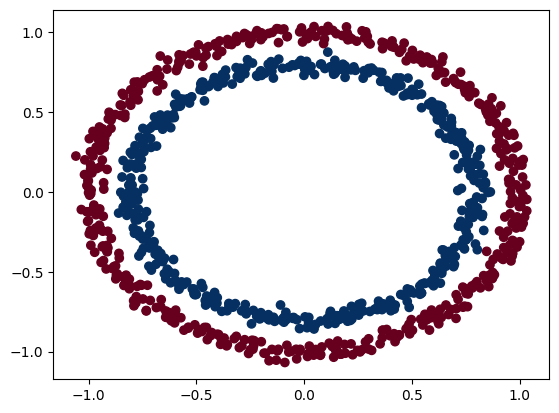

In [106]:
from torch import nn
from sklearn.datasets import make_circles

n_samples = 1000

X,y  = make_circles(n_samples,
                    noise = 0.03,
                    random_state= 42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [107]:
"""# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]"""

'# Convert to tensors and split into train and test sets\nimport torch\nfrom sklearn.model_selection import train_test_split\n\n# Turn data into tensors\nX = torch.from_numpy(X).type(torch.float)\ny = torch.from_numpy(y).type(torch.float)\n\n# Split into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X,\n                                                    y,\n                                                    test_size=0.2,\n                                                    random_state=42\n)\n\nX_train[:5], y_train[:5]'

In [108]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [109]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [110]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [111]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)

X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  #model_3.train()
  y_logits  = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss= loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()

  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss  = loss_fn(test_logits, y_test)

    test_acc = accuracy_fn( y_test, test_pred)
    #print(test_acc)
    if epoch %100 == 0:
      print(f'Epoch: {epoch}  | Loss: {loss: .5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0  | Loss:  0.69295 | Accuracy: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100  | Loss:  0.69115 | Accuracy: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200  | Loss:  0.68977 | Accuracy: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300  | Loss:  0.68795 | Accuracy: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400  | Loss:  0.68517 | Accuracy: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500  | Loss:  0.68102 | Accuracy: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600  | Loss:  0.67515 | Accuracy: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700  | Loss:  0.66659 | Accuracy: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800  | Loss:  0.65160 | Accuracy: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900  | Loss:  0.62362 | Accuracy: 74.00% | Test loss: 0.62145, Test acc: 79.00%


In [112]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

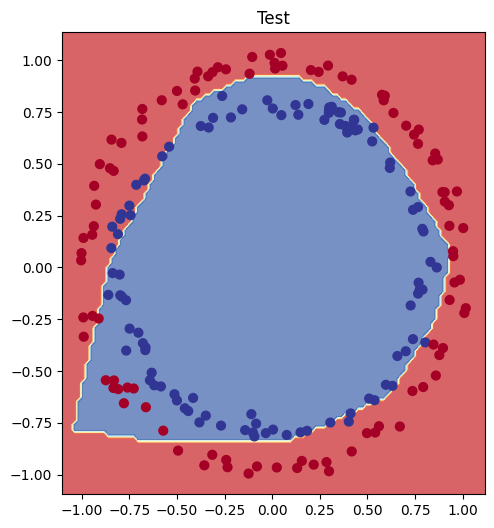

In [113]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity